In [1]:
import os

os.chdir("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
import numpy as np

from modular_splicing.gtex_data.pipeline.splice_table import produce_splice_table
from modular_splicing.gtex_data.pipeline.gtex_data_table import (
    exon_junction_data,
    gene_expr_data,
)
from modular_splicing.gtex_data.experiments.create_dataset import MarginalPsiV3
from modular_splicing.gtex_data.experiments.tissue_groups import main_tissue_groups_v1
from modular_splicing.gtex_data.annotation.compute_psis_from_annotation import (
    compute_psis_all,
)

from modular_splicing.dataset.multi_tissue_h5_dataset import (
    MultiTissueProbabilitiesH5File,
)
from modular_splicing.dataset.datapoint_extractor import BasicDatapointExtractor

In [4]:
tissue_groups = main_tissue_groups_v1

In [5]:
exons = exon_junction_data()
genes = gene_expr_data()

In [6]:
cost_params = dict(annot_cost=1e-4, other_cost=0.1)

In [7]:
ensembl_version = 89

splice_table, name_to_ensg, frac_kept = produce_splice_table()
keys_set, idxs = exons.group_tissue_ids(lambda x: x)
ensg_to_psi_dict = compute_psis_all(
    sorted(name_to_ensg.values()), cost_params, idxs, ensembl_version=ensembl_version
)

INFO:filelock:Lock 140521292456960 released on /scratch/kavig/.cache/permacache/modular_splicing/gtex_data/annotation/statistics/compute_psis_all_3/lock


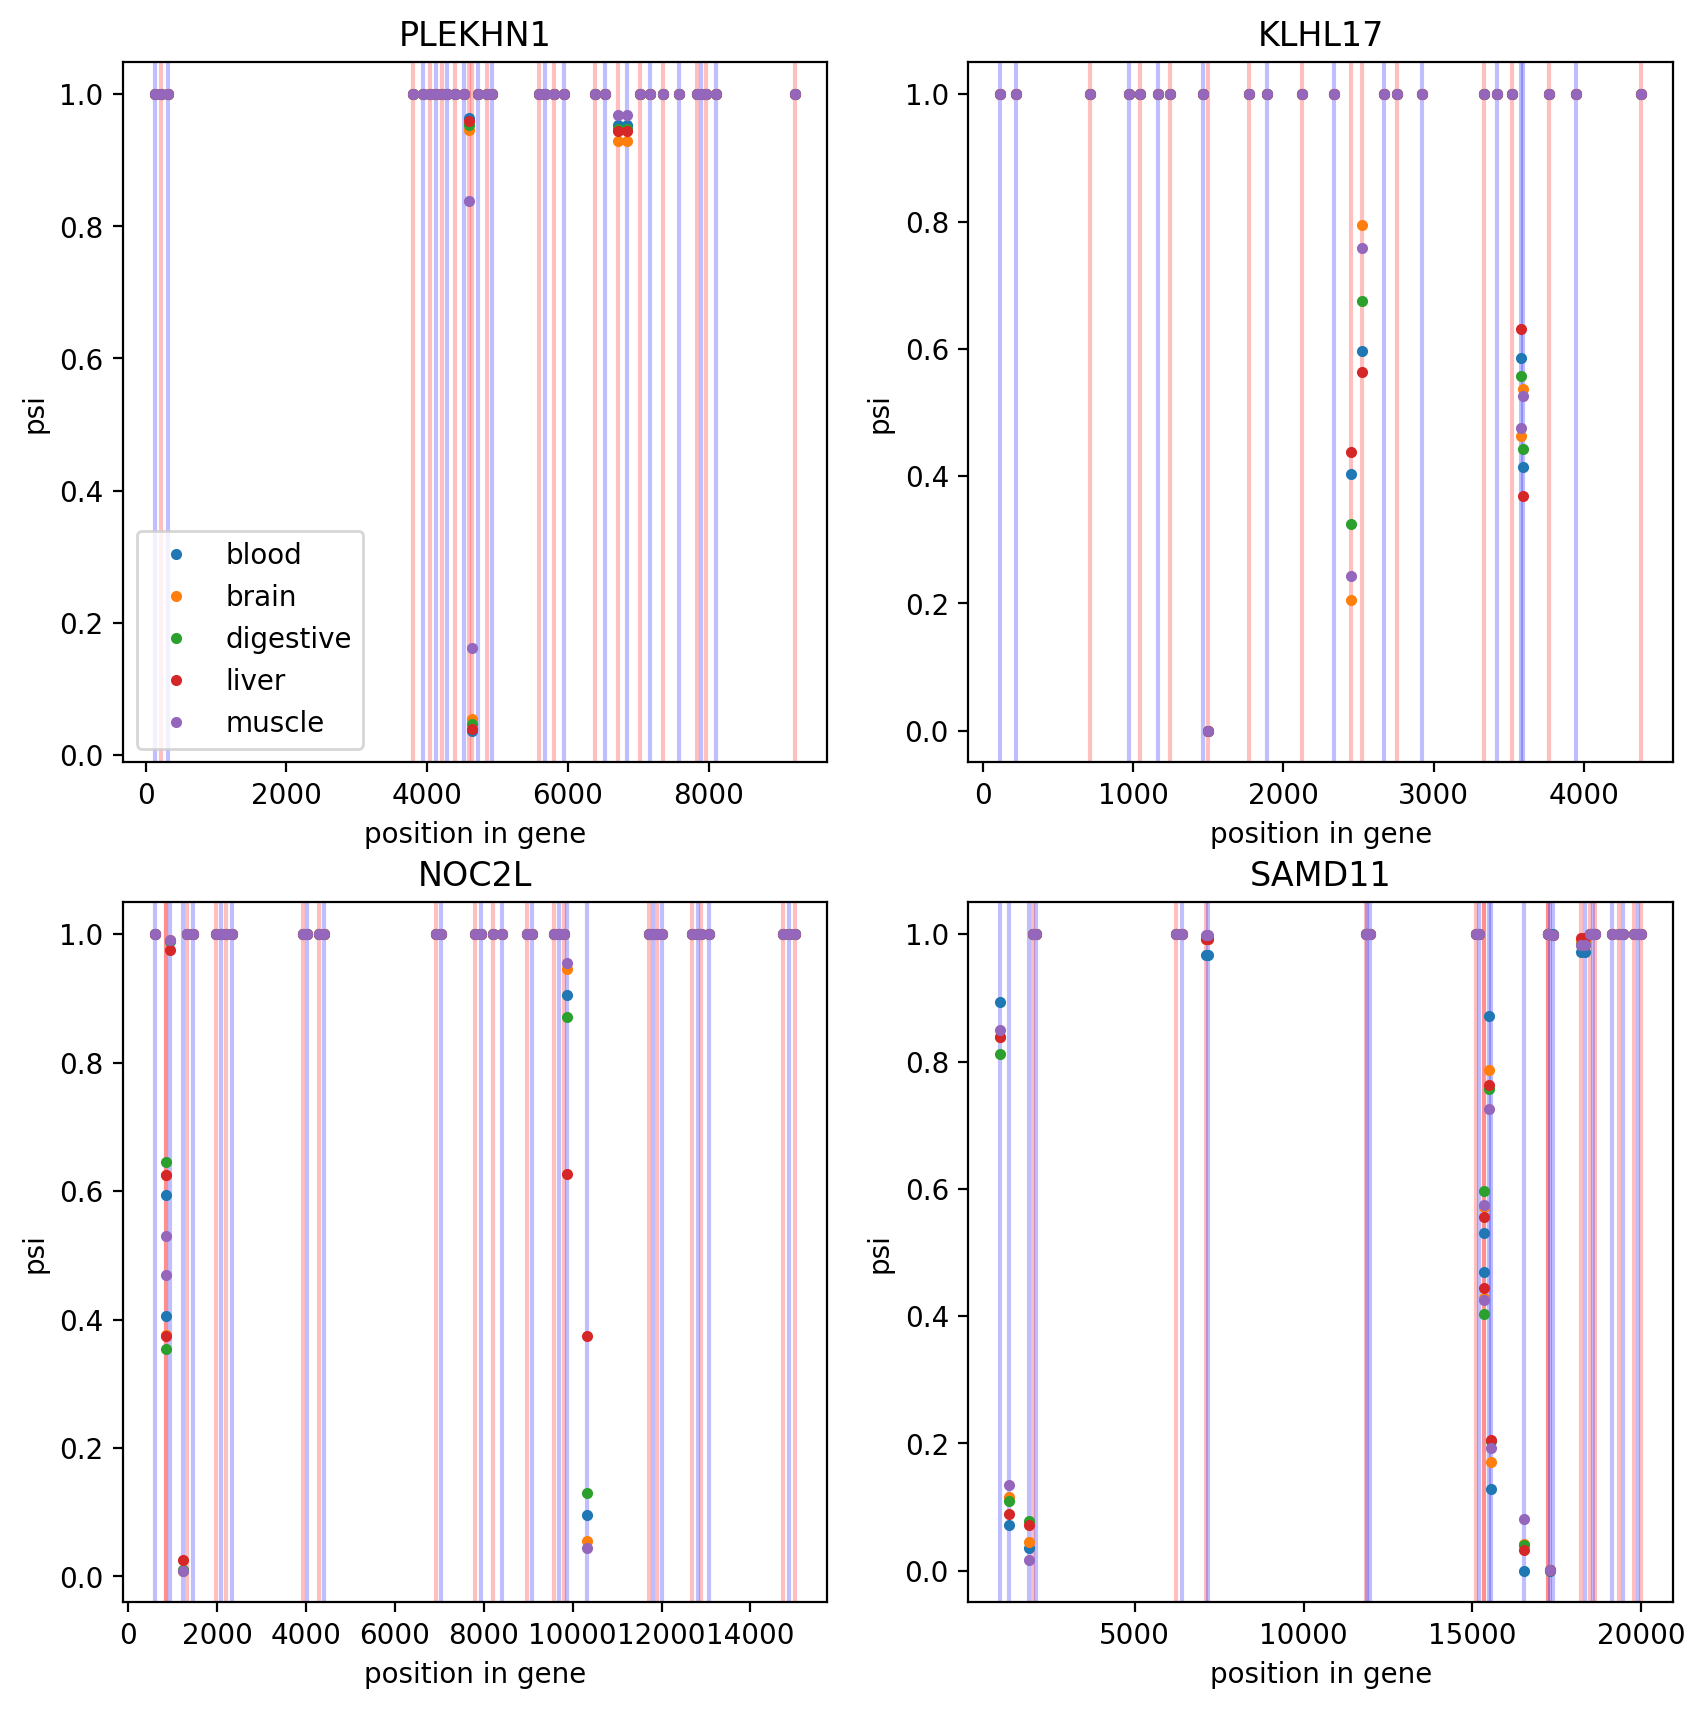

In [8]:
_, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=200)
axs = list(axs.flatten())
gene_idx = 0
while axs:
    gene_name = splice_table.iloc[gene_idx]["name"]
    start = splice_table.iloc[gene_idx].start
    gene_idx += 1
    gene_ensg = name_to_ensg[gene_name]
    psi_d = ensg_to_psi_dict[gene_ensg]
    if not psi_d["sites"]:
        continue
    ax = axs.pop()
    for site_x, which in psi_d["sites"]:
        ax.axvline(site_x - start, color={"A": "red", "D": "blue"}[which], alpha=0.25)
    for group_name, group in tissue_groups.items():
        scores = psi_d["scores_by_tissue"][[keys_set.index(x) for x in group]].mean(0)
        ax.plot(
            [x - start for x, _ in psi_d["sites"]],
            scores,
            linestyle=" ",
            marker=".",
            label=group_name,
        )
    ax.set_ylabel("psi")
    ax.set_xlabel("position in gene")
    ax.set_title(gene_name)
    if not axs:
        ax.legend()

In [9]:
overall = []
limit = 100
for gene_idx in tqdm.trange(min(len(splice_table), limit)):
    gene_name = splice_table.iloc[gene_idx]["name"]
    gene_idx += 1
    gene_ensg = name_to_ensg[gene_name]
    psi_d = ensg_to_psi_dict[gene_ensg]
    overall.extend(psi_d["scores_by_tissue"].T)
overall = np.array(overall).T

  0%|          | 0/100 [00:00<?, ?it/s]

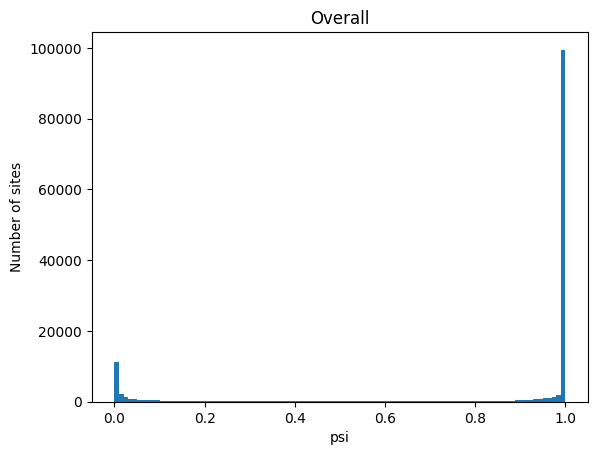

In [10]:
bins = np.linspace(0, 1, 100)
plt.hist(overall.flatten(), bins=bins)
plt.xlabel("psi")
plt.ylabel("Number of sites")
plt.title("Overall")
plt.show()

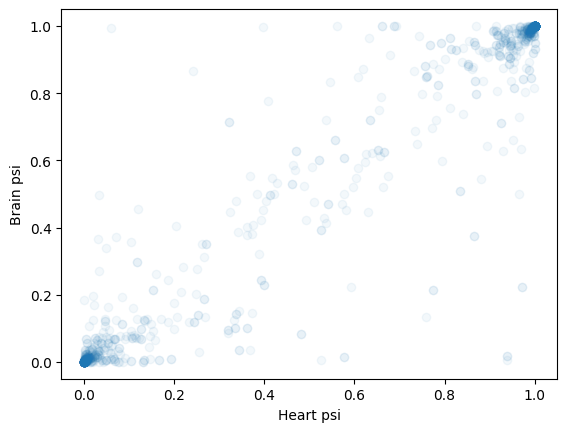

In [11]:
plt.scatter(
    overall[[keys_set.index(x) for x in tissue_groups["brain"]]].mean(0),
    overall[[keys_set.index(x) for x in tissue_groups["blood"]]].mean(0),
    alpha=0.05,
)
plt.xlabel("Heart psi")
plt.ylabel("Brain psi")
plt.show()

In [12]:
idx_order = np.argsort(np.nanmean(overall, 1))

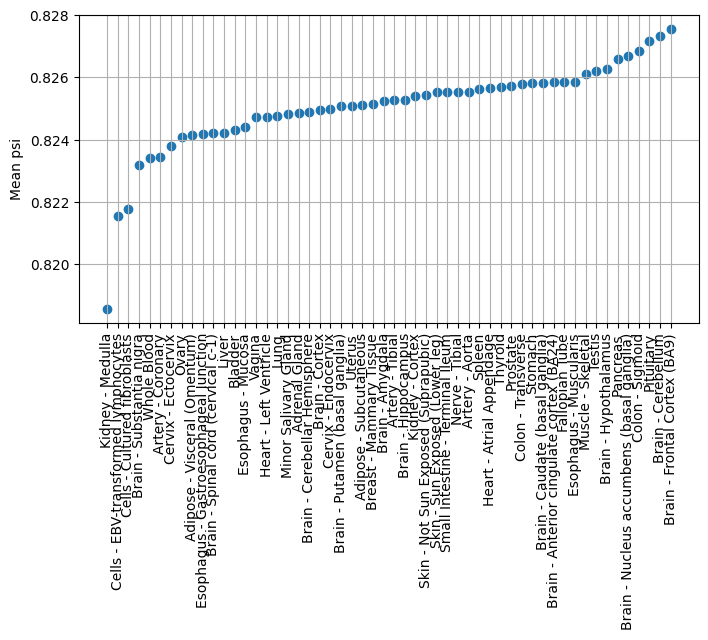

In [13]:
plt.figure(figsize=(8, 4))
plt.scatter(np.arange(overall.shape[0]), np.nanmean(overall, 1)[idx_order])
plt.xticks(np.arange(overall.shape[0]), np.array(keys_set)[idx_order], rotation=90)
plt.ylabel("Mean psi")
plt.grid()
plt.show()

In [14]:
MarginalPsiV3.create()

Fraction kept: 92.09%


INFO:filelock:Lock 140521292456960 acquired on /scratch/kavig/.cache/permacache/modular_splicing/gtex_data/annotation/statistics/compute_psis_all_3/lock
INFO:filelock:Lock 140521292456960 released on /scratch/kavig/.cache/permacache/modular_splicing/gtex_data/annotation/statistics/compute_psis_all_3/lock


Datafiles already exist, skipping creation.
Datasets already exist, skipping creation.


,name,chunk,chr,strand,start,end,start_points,end_points,start_ids,end_ids
19920,SPRY3,1,chrX,+,155767812,155782459,56960286,56954656,451833,451832
19921,VAMP7,1,chrX,+,155881293,155943769,"57075978,57082143,57084632,57087017,57106333,5...","57067968,57076067,57076128,57076132,57076153,5...","451835,451840,451842,451844,451846,451848,451850","451834,451836,451837,451838,451839,451841,4518..."
19922,IL9R,1,chrX,+,155997581,156010817,"57187850,57187928,57189402,57189426,57189969,5...","57184307,57188028,57189539,57190080,57190375,5...","451852,451853,451855,451856,451858,451860,4518...","451851,451854,451857,451859,451862,451865,4518..."
19923,WASH6P,1,chrX,+,156020826,156025710,"57208026,57208201,57208214,57208519,57208834,5...","57207668,57208083,57208312,57208665,57208979,5...","451875,451877,451878,451880,451882,451883,4518...","451874,451876,451879,451881,451884,451885,4518..."


In [15]:
dset = MultiTissueProbabilitiesH5File(
    f"{MarginalPsiV3.data_path_folder}/dataset_train_all.h5",
    datapoint_extractor=BasicDatapointExtractor(None),
    tissue_groups=tissue_groups,
)

In [16]:
dset["X0"][:].shape, dset["Y0"][:].shape

((11510, 15000, 4), (1, 11510, 5000, 3))

In [17]:
y0 = dset["Y0"][:]

In [18]:
np.sum(np.isnan(y0))

0